In [1]:
import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# defining a model
class MLP(nn.Module):
    def __init__(self, p=0.5)  -> None:
        super(MLP, self).__init__()
        self.layers = nn.Sequential(nn.Flatten(),
                                    nn.Linear(28 * 28 * 1, 1024),      
                                    nn.Dropout(p=p),
                                    nn.ReLU(),
                                    nn.Linear(1024, 512),
                                    nn.Dropout(p=p),
                                    nn.ReLU(),
                                    nn.Linear(512, 32),
                                    nn.Dropout(p=p),
                                    nn.ReLU(),
                                    nn.Linear(32, 10))
    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [3]:
# to find accuracy on the dataset
def test(model, test_dataloader, loss_function):
    tot_loss = 0
    correct_pred = 0
    data_no = 0
    model = model.eval()
    for i, data in enumerate(test_dataloader, 0):
        inputs, targets = data
        inputs = inputs.cuda()
        outputs = model(inputs)
        outputs = outputs.cpu()
        loss = loss_function(outputs, targets)
        tot_loss += loss.item()*targets.shape[0]
        pred_labels = torch.argmax(outputs, dim=1).reshape(-1)
        targets = targets.reshape(-1)
        correct_pred += torch.sum(pred_labels == targets)
        data_no += targets.shape[0]
    print(f'Test loss {tot_loss/data_no}, accuracy {correct_pred/data_no}')
    return tot_loss/data_no, correct_pred/data_no

In [4]:
# function for plotting
def plot_losses(train_losses, test_losses, ax, title):
    ax.set_xlabel('iteration/epoch no')
    ax.set_ylabel('loss')
    iterations = np.arange(len(train_losses))
    epochs = np.arange(len(test_losses))
    ax.plot(iterations, train_losses, label="train loss for " + title)
    ax.plot(epochs, test_losses, label="test loss for " + title)
    ax.legend()

def plot_accuracies(accuracies, ax, title):
    epochs = np.arange(len(accuracies))
    ax.plot(epochs, accuracies, label="test accuracy for " + title)
    ax.legend()

In [5]:
# main function for comaparing the effect of dropout
def main(epochs=5, p=0.5, batch_size=10, ax1=None, ax2=None):      
  # Set fixed random number seed
  torch.manual_seed(42)
  
  # Prepare CIFAR-10 dataset
  train_dataset = MNIST(os.getcwd(),
                        train=True,
                        download=True, 
                        transform=transforms.ToTensor())
  test_dataset = MNIST(os.getcwd(),
                       train=False,
                       download=True,
                       transform=transforms.ToTensor())
  trainloader = torch.utils.data.DataLoader(train_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=True
                                            )
  testloader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           )

  # Initialize the MLP
  mlp = MLP(p=p).cuda()
  
  # Define the loss function and optimizer
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)
  accuracies = []
  train_losses = []
  test_losses = []

  # Run the training loop
  for epoch in range(epochs): # 5 epochs at maximum    
    current_loss = 0.0
    epoch_loss = 0.0
    data_no = 0.0
    test_loss, accuracy = test(mlp, testloader, loss_function)
    test_losses.append(test_loss)
    accuracies.append(accuracy) 
    mlp = mlp.train()
    # Iterate over the DataLoader for training data
    loop = tqdm(enumerate(trainloader, 0), total=len(trainloader))
    for i, data in loop:
      inputs, targets = data
      inputs = inputs.cuda()
      optimizer.zero_grad()
      outputs = mlp(inputs)
      outputs = outputs.cpu()
      loss = loss_function(outputs, targets)
      loss.backward()
      optimizer.step()
      current_loss += loss.item()
      epoch_loss += loss.item()*targets.shape[0]
      data_no += targets.shape[0]
      if i % max(int(500*(10/batch_size)), 1) == max(int((500*10/batch_size))-1, 0):
          loop.set_description(f'Epoch no {epoch}')
          loop.set_postfix_str(f'Loss after {i+1}th minibatch: {round(current_loss, 2)}')
          # print('Loss after mini-batch %5d: %.3f' %
          #       (i + 1, current_loss / 500))
          current_loss = 0.0
    
    train_losses.append(epoch_loss/data_no)
    print(f"Train loss {epoch_loss/data_no}")
  title = f" p: {p}"
  plot_losses(train_losses, test_losses, ax1, title)
  plot_accuracies(accuracies, ax2, title)
  # Process is complete.
  print('Training process has finished for ' + title + " max acc: ", max(accuracies))

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ps = [0, 0.25, 0.5]
batch_size = 4096
epochs=100
for p in ps:
    main(epochs=epochs, p=p, batch_size=batch_size, ax1=ax1, ax2=ax2)

Test loss 2.308241564178467, accuracy 0.09740000218153


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 1.5376847860336305
Test loss 0.5772205330848694, accuracy 0.8245999813079834


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.4560828261693319
Test loss 0.3516164258956909, accuracy 0.8996000289916992


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.3236096908887227
Test loss 0.28280816721916197, accuracy 0.9169999957084656


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.26814611047108966
Test loss 0.23999881265163422, accuracy 0.9308000206947327


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.2274127726872762
Test loss 0.2116739779472351, accuracy 0.9377999901771545


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.19649080843130748
Test loss 0.18637911777496338, accuracy 0.944599986076355


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.17092665394147238
Test loss 0.16402204022407532, accuracy 0.9521999955177307


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.15052945074240368
Test loss 0.14889625030755996, accuracy 0.9574000239372253


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.13236726512908936
Test loss 0.1349353368282318, accuracy 0.9599999785423279


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.1186719909230868
Test loss 0.12713474714756012, accuracy 0.9621999859809875


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.10645267533461253
Test loss 0.11696884199380875, accuracy 0.9639000296592712


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.0973960820198059
Test loss 0.11171337268352509, accuracy 0.9661999940872192


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.08832789163589477
Test loss 0.10365521802902222, accuracy 0.9678999781608582


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.07785500679810842
Test loss 0.09744255385398864, accuracy 0.9710000157356262


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.06938146134614945
Test loss 0.09465589785575866, accuracy 0.9717000126838684


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.06434886618057886
Test loss 0.08718009885549545, accuracy 0.9728999733924866


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.05732069666385651
Test loss 0.08529814330339432, accuracy 0.9739000201225281


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.05417835889657339
Test loss 0.08261163730621338, accuracy 0.9739999771118164


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.04862756341099739
Test loss 0.08166422072649002, accuracy 0.9749000072479248


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.04422759485840797
Test loss 0.07823982599973679, accuracy 0.9763000011444092


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.0401808470706145
Test loss 0.07228364408016205, accuracy 0.9779000282287598


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.03573513974348704
Test loss 0.07338385311365128, accuracy 0.9778000116348267


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.032286843590935074
Test loss 0.07439487011432648, accuracy 0.977400004863739


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.029259309444824855
Test loss 0.07144177412390709, accuracy 0.9782000184059143


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.02695682677725951
Test loss 0.07356516278982163, accuracy 0.9776999950408936


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.0238397218644619
Test loss 0.06945735499858856, accuracy 0.9789999723434448


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss 0.022421082440018655
Test loss 0.07526791082620621, accuracy 0.9782999753952026


  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
def main_transforms(epochs=5, 
                   batch_size=10, 
                   ax1=None, 
                   ax2=None,
                   def_trans=True,
                   train_transforms=transforms.Compose([transforms.ToTensor()]),
                   test_transforms=transforms.Compose([transforms.ToTensor()])
                   ):      
  # Set fixed random number seed
  torch.manual_seed(42)
  
  # Prepare CIFAR-10 dataset
  train_dataset = MNIST(os.getcwd(),
                        train=True,
                        download=True, 
                        transform=train_transforms)
  test_dataset = MNIST(os.getcwd(),
                       train=False,
                       download=True,
                       transform=test_transforms)
  trainloader = torch.utils.data.DataLoader(train_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=True
                                            )
  testloader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           )

  # Initialize the MLP
  mlp = MLP(p=0).cuda()
  
  # Define the loss function and optimizer
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)
  accuracies = []
  train_losses = []
  test_losses = []

  # Run the training loop
  for epoch in range(epochs): # 5 epochs at maximum    
    current_loss = 0.0
    epoch_loss = 0.0
    data_no = 0.0
    test_loss, accuracy = test(mlp, testloader, loss_function)
    test_losses.append(test_loss)
    accuracies.append(accuracy) 
    mlp = mlp.train()
    # Iterate over the DataLoader for training data
    loop = tqdm(enumerate(trainloader, 0), total=len(trainloader))
    for i, data in loop:
      inputs, targets = data
      inputs = inputs.cuda()
      optimizer.zero_grad()
      outputs = mlp(inputs)
      outputs = outputs.cpu()
      loss = loss_function(outputs, targets)
      loss.backward()
      optimizer.step()
      current_loss += loss.item()
      epoch_loss += loss.item()*targets.shape[0]
      data_no += targets.shape[0]
      if i % max(int(500*(10/batch_size)), 1) == max(int((500*10/batch_size))-1, 0):
          loop.set_description(f'Epoch no {epoch}')
          loop.set_postfix_str(f'Loss after {i+1}th minibatch: {round(current_loss, 2)}')
          # print('Loss after mini-batch %5d: %.3f' %
          #       (i + 1, current_loss / 500))
          current_loss = 0.0
    
    train_losses.append(epoch_loss/data_no)
    print(f"Train loss {epoch_loss/data_no}")
  title = " no augmentation" if def_trans else " custom data augmentation"
  plot_losses(train_losses, test_losses, ax1, title)
  plot_accuracies(accuracies, ax2, title)
  # Process is complete.
  print('Training process has finished.')
# mean 0.1307 std 0.3081
train_transforms = transforms.Compose([transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                       transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.1307], std=[0.3081])])
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.1307], std=[0.3081])])


Test loss 2.3082416465759277, accuracy 0.09740000218153


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.6987213080724081
Test loss 0.2773937888622284, accuracy 0.91839998960495


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.23745940068562826
Test loss 0.19713779368400575, accuracy 0.9416999816894531


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.1610111071149508
Test loss 0.13995561723709107, accuracy 0.9595000147819519


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.12028082803885141
Test loss 0.12066864175796509, accuracy 0.9631999731063843


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.09487511407931645
Test loss 0.09732065608501435, accuracy 0.9700999855995178


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.07308558077613513
Test loss 0.08425593594312668, accuracy 0.9735999703407288


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.060826775165398916
Test loss 0.07491817797422409, accuracy 0.9760000109672546


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.048095360231399535
Test loss 0.0767215824007988, accuracy 0.9764000177383423


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.04005832673708598
Test loss 0.07227043399810791, accuracy 0.9771000146865845


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.03157007754246394
Test loss 0.06575139504671097, accuracy 0.9793000221252441


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0241193120410045
Test loss 0.06293859204053878, accuracy 0.98089998960495


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.018681716664632163
Test loss 0.06732751480340958, accuracy 0.9797999858856201


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.015709801166256268
Test loss 0.06681599037647247, accuracy 0.9800999760627747


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.01231318639020125
Test loss 0.06680126276016235, accuracy 0.9797999858856201


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.009796915049850941
Test loss 0.07310258103609085, accuracy 0.9797000288963318


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.008303653847177824
Test loss 0.06793216460943222, accuracy 0.98089998960495


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00848292829245329
Test loss 0.0705536149740219, accuracy 0.9811000227928162


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.005851622495055199
Test loss 0.07284955486059189, accuracy 0.9807000160217285


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0035988293608650566
Test loss 0.06979356867074966, accuracy 0.9807999730110168


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.002221378078435858
Test loss 0.07154660869836807, accuracy 0.9815999865531921


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0017669679986312985
Test loss 0.07019015226364135, accuracy 0.9821000099182129


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0012686405084406337
Test loss 0.0748369844675064, accuracy 0.9818999767303467


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00102155781618009
Test loss 0.07390744255781173, accuracy 0.982200026512146


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0008749328646187981
Test loss 0.07588792626857757, accuracy 0.9815999865531921


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0006596694552339613
Test loss 0.07795359015464783, accuracy 0.9812999963760376


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0005685377966146916
Test loss 0.07677068883180618, accuracy 0.982200026512146


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.000503404633825024
Test loss 0.07817494869232178, accuracy 0.9818999767303467


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0004523170440768202
Test loss 0.07928834046125412, accuracy 0.9815999865531921


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0004026088744091491
Test loss 0.08010735193490982, accuracy 0.9815999865531921


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00036331447081950805
Test loss 0.08027947572469711, accuracy 0.9817000031471252


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00032871259320527314
Test loss 0.08091970155239105, accuracy 0.9811999797821045


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0003036672120137761
Test loss 0.08148214244842529, accuracy 0.9815000295639038


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00027529567090484004
Test loss 0.08190346869230271, accuracy 0.9819999933242798


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0002592413362270842
Test loss 0.08255044977664948, accuracy 0.9822999835014343


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00024180597634209942
Test loss 0.08365345187187195, accuracy 0.9815999865531921


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0002141907929753264
Test loss 0.08378428966999053, accuracy 0.9817000031471252


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00019719945249768595
Test loss 0.08418952649831772, accuracy 0.9811999797821045


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0001833208954737832
Test loss 0.08501896028518677, accuracy 0.9815999865531921


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00017321160005715985
Test loss 0.08570474091768265, accuracy 0.9815000295639038


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00016034965291619301
Test loss 0.08627095308303832, accuracy 0.9817000031471252


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0001490896619972773
Test loss 0.08727023556232452, accuracy 0.9817000031471252


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00013865641466497133
Test loss 0.08714724897146225, accuracy 0.9815999865531921


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00013211148692450175
Test loss 0.08811324532032012, accuracy 0.9818999767303467


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00012549511263302218
Test loss 0.08784665977954864, accuracy 0.9817000031471252


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00011563024372638513
Test loss 0.0887565805196762, accuracy 0.9818999767303467


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00011039600571772705
Test loss 0.0892682794213295, accuracy 0.9821000099182129


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.00010293147529397781
Test loss 0.0897975352048874, accuracy 0.9818000197410583


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 9.607776002182315e-05
Test loss 0.09030075601339341, accuracy 0.9818999767303467


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 9.039787811537583e-05
Test loss 0.09075975900888443, accuracy 0.9815999865531921


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 8.599794405745342e-05
Training process has finished.
Test loss 2.3113429363250733, accuracy 0.09759999811649323


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 1.0787758418242137
Test loss 0.2692513777256012, accuracy 0.9211999773979187


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.3840715956370036
Test loss 0.13561925354003906, accuracy 0.958899974822998


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.26256766437689466
Test loss 0.10561984897851943, accuracy 0.9667999744415283


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.21220071581204733
Test loss 0.07817726861238479, accuracy 0.9746999740600586


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.18058590315977732
Test loss 0.06758429185152054, accuracy 0.9782999753952026


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.15802001423041026
Test loss 0.061775301110744474, accuracy 0.9814000129699707


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.14620578249295552
Test loss 0.05595849024653435, accuracy 0.9811999797821045


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.13279030873775483
Test loss 0.05616252370476723, accuracy 0.9817000031471252


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.13048553509712219
Test loss 0.0545580805182457, accuracy 0.9818000197410583


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.1184400837580363
Test loss 0.049711560302972795, accuracy 0.9839000105857849


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.11027218704223633
Test loss 0.042826571518182754, accuracy 0.9864000082015991


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.10770809053579966
Test loss 0.044680045568943026, accuracy 0.9861000180244446


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.10524644205172856
Test loss 0.04321659569740295, accuracy 0.9860000014305115


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0984900300224622
Test loss 0.03965144992470741, accuracy 0.9872999787330627


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.09934236588478089
Test loss 0.039209699046611785, accuracy 0.9854999780654907


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.09091081501642863
Test loss 0.0374746451318264, accuracy 0.9883000254631042


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.08868609690666199
Test loss 0.038044756454229355, accuracy 0.9868999719619751


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.08735701818068822
Test loss 0.039999041128158566, accuracy 0.9869999885559082


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0817288741350174
Test loss 0.030327786767482757, accuracy 0.989799976348877


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.08064924926360448
Test loss 0.0366873495221138, accuracy 0.9883000254631042


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.07814694916009902
Test loss 0.03246595605015755, accuracy 0.9889000058174133


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.07874861223697663
Test loss 0.0366348286986351, accuracy 0.9879000186920166


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.07525803399085998
Test loss 0.03418291556239128, accuracy 0.9884999990463257


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.07317539697488148
Test loss 0.033741098403930664, accuracy 0.9883999824523926


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.07233987725377083
Test loss 0.034917276978492735, accuracy 0.9882000088691711


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.07029978841543198
Test loss 0.030228187030553817, accuracy 0.9902999997138977


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.06866588134169578
Test loss 0.0320175504386425, accuracy 0.9894999861717224


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.06915314371188482
Test loss 0.03163319597244263, accuracy 0.9887999892234802


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0685098008354505
Test loss 0.033234935921430585, accuracy 0.9891999959945679


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.06936657181580862
Test loss 0.02932940546274185, accuracy 0.9901999831199646


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.06413177224596342
Test loss 0.030646491476893425, accuracy 0.989300012588501


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.06707990881005924
Test loss 0.027513526740670206, accuracy 0.9897000193595886


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0651585908571879
Test loss 0.03265933163166046, accuracy 0.9891999959945679


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.06577543346484502
Test loss 0.02890955943465233, accuracy 0.989799976348877


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.06074194412032763
Test loss 0.027454407849907873, accuracy 0.9900000095367432


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0604726527094841
Test loss 0.03144559339284897, accuracy 0.9891999959945679


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.06025554321606954
Test loss 0.03123669790029526, accuracy 0.9897000193595886


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.056331957888603214
Test loss 0.03573617767095566, accuracy 0.9872000217437744


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.057678833297888435
Test loss 0.03069625918865204, accuracy 0.9879999756813049


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0601573154091835
Test loss 0.03108993364572525, accuracy 0.9890999794006348


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.056293395431836445
Test loss 0.03370988052487373, accuracy 0.9890999794006348


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.057193361385663354
Test loss 0.02796249872148037, accuracy 0.9901000261306763


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.056249324141939484
Test loss 0.02941752583682537, accuracy 0.9900000095367432


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.0546380700469017
Test loss 0.02543734568655491, accuracy 0.9911999702453613


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.05578770654996236
Test loss 0.02910741835832596, accuracy 0.9896000027656555


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.053333466237783435
Test loss 0.034357827442884445, accuracy 0.9879999756813049


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.05648304560780525
Test loss 0.030349351236224176, accuracy 0.9904000163078308


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.05047570172746976
Test loss 0.0322632910490036, accuracy 0.9886000156402588


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.05099669422705968
Test loss 0.02924214169383049, accuracy 0.9901000261306763


  0%|          | 0/59 [00:00<?, ?it/s]

Train loss 0.05084118472238382
Training process has finished.


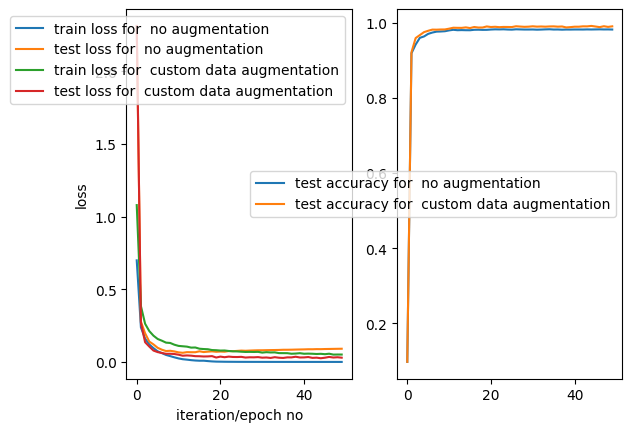

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
main_transforms(50, 1024, ax1, ax2)
main_transforms(50, 1024, ax1, ax2, 
                False, train_transforms, 
                test_transforms)
# main(50, 1024, ax1, ax2, True)